In [38]:
import numpy as np
import matplotlib.pyplot as plt
import qnmfits
import funcs.CCE as CCE
from funcs.likelihood_funcs import * 
from funcs.utils import *
from funcs.kernel_param_funcs import *
from funcs.qnm_selecting_funcs import *
import corner
import scipy
import pickle 

In [39]:
ID = "0001" 

In [40]:
# Noise data for CCE sims 

with open('param_dict_sim_lm_full.pkl', 'rb') as f:
    params = pickle.load(f)

with open('R_dict_sim_lm_full.pkl', 'rb') as f:
    R = pickle.load(f)

In [41]:
# White noise

tuning_hyperparams_s = [0.3996582031249995]  

hyperparam_rule_dict_s = {
    "sigma_max": "multiply",
}

tuned_param_dict_wn = {mode: get_new_params(params[ID][mode], tuning_hyperparams_s, hyperparam_rule_dict_s) for mode in params[ID]}

Set up all parameters for minimal working example 

In [ ]:
######################################################################################################

# Mock data parameters 

DATA_AMPS = [0.4, 0.2, -0.04, -0.2] # These are based on 0001 

DATA_QNMS = [(2, 2, 0, 1), (2, 2, 1, 1)]
DATA_SPHERICAL_MODES = [(2, 2)]
sim_main = CCE.SXS_CCE(ID, lev="Lev5", radius="R2")
DATA_MASS = sim_main.Mf
DATA_SPIN = sim_main.chif_mag 

DATA_TIME_STEP = 0.1

DATA_T0 = -10 # This needs to be consistent with training start (can't start arbitrarily far back)
DATA_T = 100

data_times = np.arange(
    DATA_T0, DATA_T0 + DATA_T, DATA_TIME_STEP
)

####################################################################################################

TRAINING_TIME_STEP = 0.1 
TRAINING_T0 = -10
TRAINING_T = 100

training_times = np.arange(
    TRAINING_T0, TRAINING_T0 + TRAINING_T, TRAINING_TIME_STEP
)

TRAINING_SPH_MODES = [(2,2)]


####################################################################################################

ANALYSIS_TIME_STEP = 0.1
ANALYSIS_T0 = 10
ANALYSIS_T = 100

analysis_times = np.arange(
    ANALYSIS_T0, ANALYSIS_T0 + ANALYSIS_T, ANALYSIS_TIME_STEP
)

MODEL = [(2,2,0,1), (2,2,1,1)]
SPH_MODES = [(2,2)]


Functions to get mock data and noise

In [50]:
# Get mock data with noise functions

def get_mock_data(times, t0, amps, qnm_list, spherical_modes, mass, spin):
    mock_data = {mode: np.zeros_like(times, dtype=complex) for mode in spherical_modes}
    for i, qnm in enumerate(qnm_list):
        amp = amps[2 * i] + 1j * amps[2 * i + 1]
        omega = qnmfits.qnm.omega(*qnm, spin, Mf=mass)
        for ell, m in spherical_modes:
            mu = qnmfits.qnm.mu(ell, m, qnm[0], qnm[1], qnm[2], qnm[3], spin)
            mock_data[ell, m] += amp * mu * np.exp(-1j * omega * (times - t0))
    return mock_data

def get_noisy_mock_data(mock_data, kernel_dict, times):
    data = mock_data.copy()
    rng = np.random.default_rng()
    repeats = 1
    noise = {mode: np.zeros_like(times, dtype=complex) for mode in mock_data.keys()}
    for ell, m in data.keys():
        gp_samples = rng.multivariate_normal(np.zeros(len(times)), kernel_dict[ell,m], size=repeats)
        for j, draw in enumerate(gp_samples):
            data[ell, m] += draw
            noise[ell, m] += draw 
        #noise[ell, m] /= np.sqrt(repeats)
    return data, noise

In [ ]:
tuning_hyperparams_data = [1, 0, 3, 0.5] 

HYPERPARAM_RULE_DICT = {
    "sigma_max": "multiply",
    "t_s": "sum",
    "length_scale": "multiply",
    "period": "multiply",
}

tuned_params_data = {mode: get_new_params(params[ID][mode], tuning_hyperparams_data, HYPERPARAM_RULE_DICT) for mode in params[ID]}

In [ ]:
mock_kernel_dict = {
    mode: compute_kernel_matrix(data_times, tuned_params_data[mode], kernel_main)
    for mode in tuned_params_data.keys()
}

mock_h = get_mock_data(data_times, DATA_T0, DATA_AMPS, DATA_QNMS, DATA_SPHERICAL_MODES, DATA_MASS, DATA_SPIN)
data, noise = get_noisy_mock_data(mock_h, mock_kernel_dict, data_times)

#################################################################################################################################################################

# Training on different time grids

In [57]:
SIM_TRAINING_MODE_RULES = {
    "0001": "PE", # used as a placeholder number (not CCE)
}

SIGMA_MAX_LOWER, SIGMA_MAX_UPPER = 0.1, 5
T_S_LOWER, T_S_UPPER = -20, 30
LENGTH_SCALE_LOWER, LENGTH_SCALE_UPPER = 0.1, 5
PERIOD_LOWER, PERIOD_UPPER = 0.1, 5

BOUNDS = [
    (SIGMA_MAX_LOWER, SIGMA_MAX_UPPER),
    (T_S_LOWER, T_S_UPPER),
    (LENGTH_SCALE_LOWER, LENGTH_SCALE_UPPER),
    (PERIOD_LOWER, PERIOD_UPPER),
]

INITIAL_PARAMS = [1, 0, 3, 0.5] 

HYPERPARAM_RULE_DICT = {
    "sigma_max": "multiply",
    "t_s": "sum",
    "length_scale": "multiply",
    "period": "multiply",
}

In [ ]:
sampling_rates = np.arange(0.1, 1.1, 0.1)

for i, dt in enumerate(sampling_rates):

    data_times_downsampled = np.arange(
                DATA_T0, DATA_T0 + DATA_T, dt
                )
    
    noise_data_downsampled = sim_interpolator_data(noise, data_times, data_times_downsampled)
    R_data = {'0001': noise_data_downsampled}

    hyperparam_list, le = get_minimised_hyperparams(
        INITIAL_PARAMS,
        BOUNDS,
        params, # I am assuming that the params don't change with different sampling rates (all that would change is sigma max/min). Actually given that this is fixed when introducing noise to the mock data
        # I think it's better it doesn't change? 
        R_data,
        HYPERPARAM_RULE_DICT,
        data_times_downsampled,
        kernel_main,
        TRAINING_SPH_MODES,
        SIM_TRAINING_MODE_RULES,
    )

    print("Sampling rate:", dt)
    print(
        "Optimal parameters:",
        dict(zip(HYPERPARAM_RULE_DICT.keys(), hyperparam_list)),
        "Log evidence:",
        le,
    )

In [ ]:
ls_fit = qnmfits.multimode_ringdown_fit(
    data_times,
    data,
    modes=MODEL,
    Mf=DATA_MASS,
    chif=DATA_SPIN,
    t0=ANALYSIS_T0,
    T=ANALYSIS_T,
    spherical_modes=SPH_MODES,
)
 
C_0 = ls_fit["C"]

true_params = []
for re_c, im_c in zip(np.real(ls_fit["C"]), np.imag(ls_fit["C"])):
    true_params.append(re_c)
    true_params.append(im_c)

In [ ]:
# White noise kernel

fit_wn = qnm_BGP_fit(
        data_times,
        data,
        MODEL,
        DATA_MASS,
        DATA_SPIN,
        ANALYSIS_T0,
        tuned_param_dict_wn,
        kernel_s,
        t0_method="geq",
        T=ANALYSIS_T,
        spherical_modes=SPH_MODES,
    )


fit_wn_downsampled = qnm_BGP_fit(
        data_times_downsampled,
        data_downsampled,
        MODEL,
        DATA_MASS,
        DATA_SPIN,
        ANALYSIS_T0,
        tuned_param_dict_wn,
        kernel_s,
        t0_method="geq",
        T=ANALYSIS_T,
        spherical_modes=SPH_MODES,
    )

# Standard kernel 

fit_main = qnm_BGP_fit(
        data_times,
        data,
        MODEL,
        DATA_MASS,
        DATA_SPIN,
        ANALYSIS_T0,
        tuned_params_lm,
        kernel_test_stationary,
        t0_method="geq",
        T=ANALYSIS_T,
        spherical_modes=SPH_MODES,
    )

fit_main_downsampled = qnm_BGP_fit(
        data_times_downsampled,
        data_downsampled,
        MODEL,
        DATA_MASS,
        DATA_SPIN,
        ANALYSIS_T0,
        tuned_params_lm,
        kernel_test_stationary,
        t0_method="geq",
        T=ANALYSIS_T,
        spherical_modes=SPH_MODES,
)

IndexError: boolean index did not match indexed array along dimension 0; dimension is 1000 but corresponding boolean dimension is 96

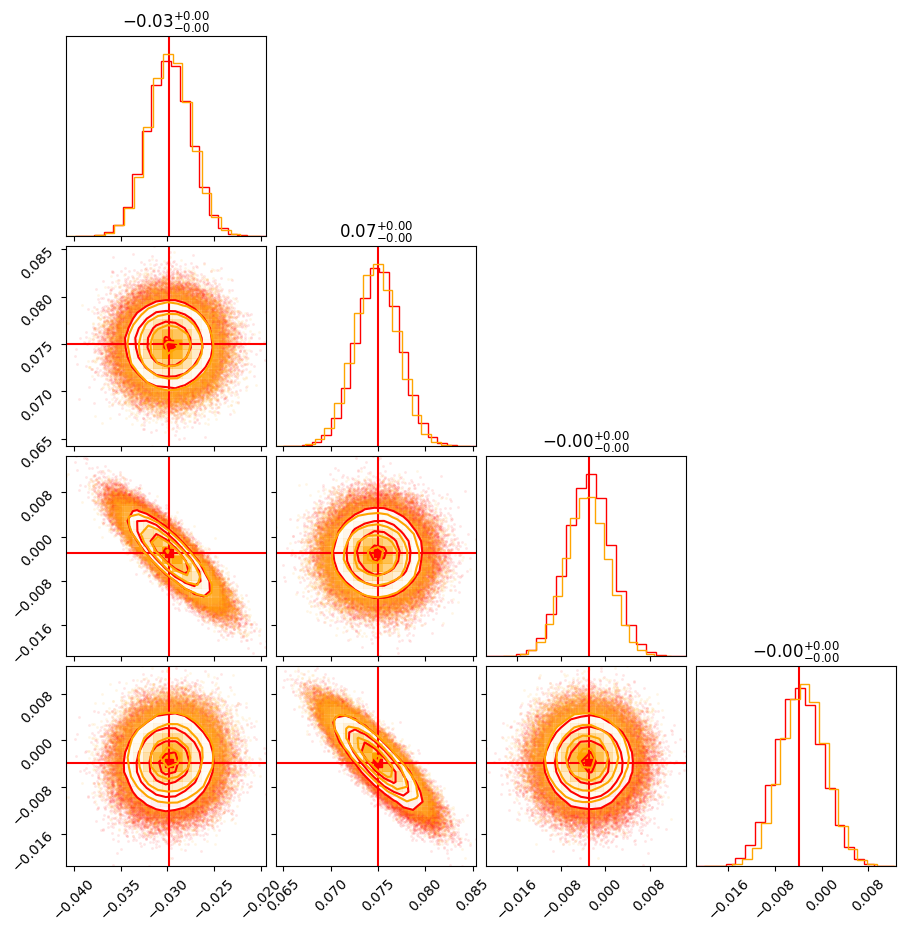

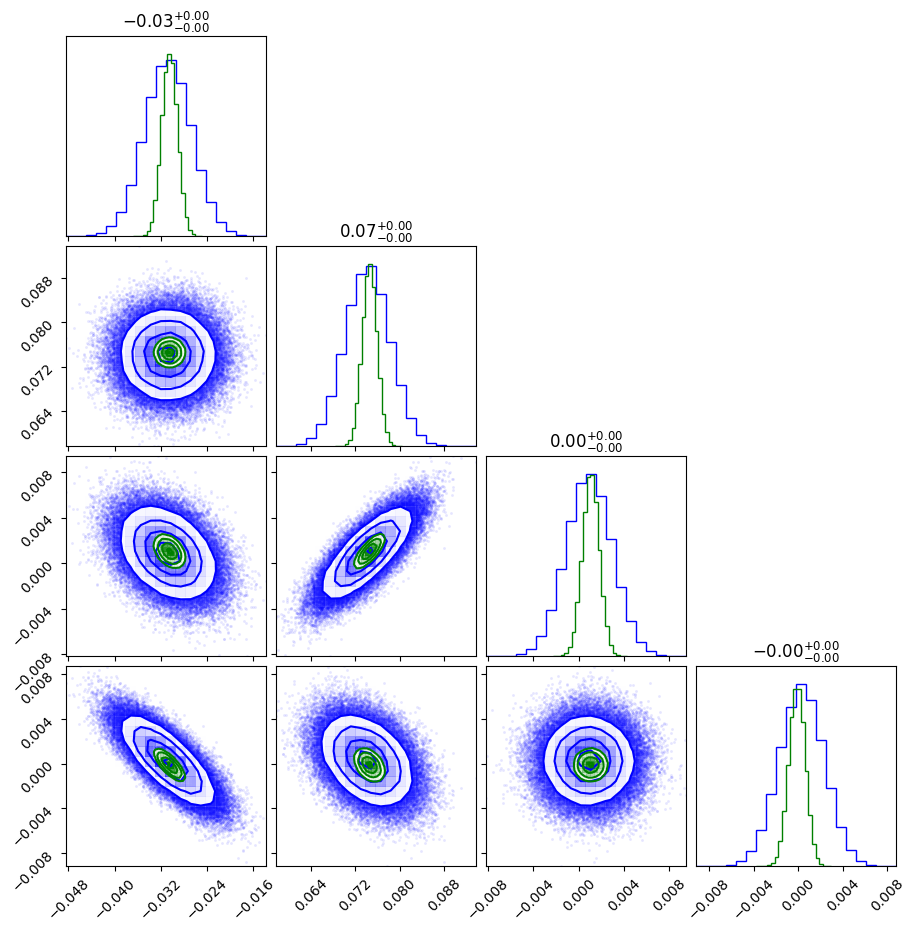

In [ ]:
samples_s = scipy.stats.multivariate_normal(fit_wn['mean'], fit_wn['covariance'], allow_singular=True).rvs(
    size=100000
)

samples_s_downsampled = scipy.stats.multivariate_normal(fit_wn_downsampled['mean'], fit_wn_downsampled['covariance'], allow_singular=True).rvs(
    size=100000
)


samples = scipy.stats.multivariate_normal(fit_main['mean'], fit_main['covariance'], allow_singular=True).rvs(
    size=100000
)

samples_downsampled = scipy.stats.multivariate_normal(fit_main_downsampled['mean'], fit_main_downsampled['covariance'], allow_singular=True).rvs(
    size=100000
)

figure = corner.corner(
    samples_s,
    truths=true_params,
    color='red',
    truth_color='red',
    label_kwargs={"fontsize": 12},
    show_titles=True,
    title_kwargs={"fontsize": 12}
)

figure = corner.corner(
    samples_s_downsampled,
    color='orange',
    fig=figure,
    alpha = 0.2,
    label_kwargs={"fontsize": 12},
    show_titles=True,
    title_kwargs={"fontsize": 12}
)

figure = corner.corner(
    samples,
    color='blue',
    truths=DATA_AMPS,
    truth_color='blue',
    #fig=figure,
    label_kwargs={"fontsize": 12},
    show_titles=True,
    title_kwargs={"fontsize": 12}
) 

figure = corner.corner(
    samples_downsampled,
    color='green',
    truth_color='green',
    alpha = 0.2,
    fig=figure,
    label_kwargs={"fontsize": 12},
    show_titles=True,
    title_kwargs={"fontsize": 12}
)


plt.show()